# Forecasting Carbon Intensity using SARIMA #

## Importing modules ##

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
    
import sys, os
import time
# Add path to power_monitor
sys.path.append(os.path.abspath('../../LibreHardwareMonitor-net472'))
from power_monitor import PowerMonitor
    
# Dictionary to store execution times for each code block
execution_times = {}
power_stats = {}
    
# Set thread limits
os.environ['OMP_NUM_THREADS'] = '4'
os.environ['MKL_NUM_THREADS'] = '4'

## Processing data for monthly carbon intensity ##

In [2]:
with PowerMonitor(filename = "bulk_monthly_SARIMA.csv") as pm:
    start_time = time.time()
    df = pd.read_csv('../../data/df_fuel_ckan.csv')
    df['DATETIME'] = pd.to_datetime(df['DATETIME'])
    df_filtered = df[df['DATETIME'].dt.year < 2025].copy()
    df_filtered.set_index('DATETIME', inplace=True)
    data_train = df_filtered['CARBON_INTENSITY'].resample('M').mean().dropna()
    data_train.head()
    execution_times['Data Processing'] = time.time() - start_time
power_stats['Data Processing'] = pm.stats()

C:\Users\tianw\AppData\Local\Temp\ipykernel_9136\1471436749.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_train = df_filtered['CARBON_INTENSITY'].resample('M').mean().dropna()


## Fitting a SARIMA model to the data ##

In [3]:
with PowerMonitor(filename = "bulk_monthly_SARIMA.csv") as pm:
    start_time = time.time()
    model = pmdarima.auto_arima(
        data_train,
        start_p=1,
        d=1,
        start_q=1,
        max_p=3,
        max_d=3,
        max_q=3,
        seasonal=True,
        m=12,
        suppress_warnings=True,
        error_action='ignore',
        n_jobs=-1,
        threads=4
    )
    execution_times['Model definition'] = time.time() - start_time
power_stats['Model definition'] = pm.stats()

c:\Users\tianw\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


## Generating and Plotting Forecasts for 2025 ##

c:\Users\tianw\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


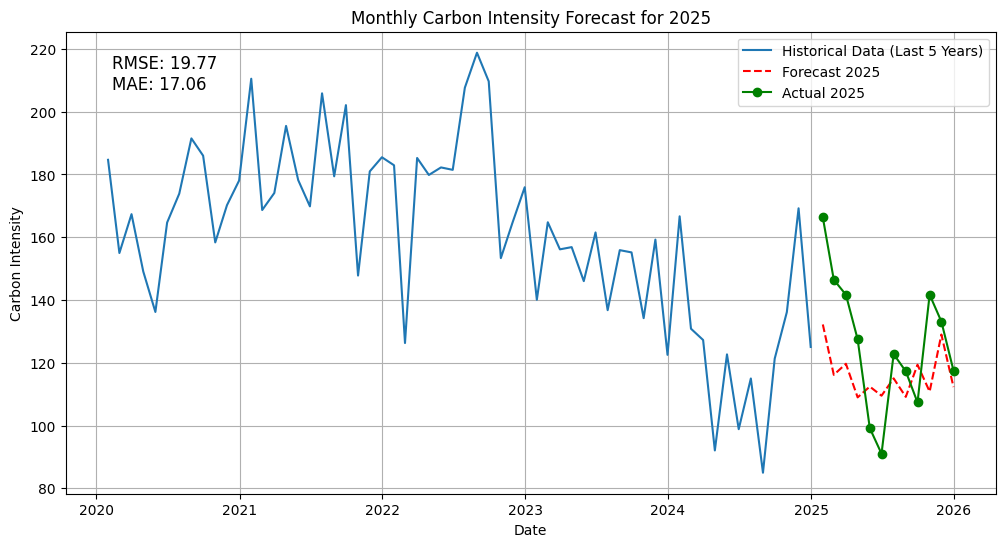

In [4]:
# Forecast for 2025 (12 months)
with PowerMonitor(filename = "bulk_monthly_SARIMA.csv"):
    start_time = time.time()
    forecast_mean = model.predict(n_periods=12)

    # Get actual 2025 data for comparison
    df_2025 = df[df['DATETIME'].dt.year == 2025].copy()
    df_2025.set_index('DATETIME', inplace=True)
    # Handle resampling compatibility
    try:
        actual_2025 = df_2025['CARBON_INTENSITY'].resample('ME').mean().dropna()
    except ValueError:
        actual_2025 = df_2025['CARBON_INTENSITY'].resample('M').mean().dropna()

    RMSE = mean_squared_error(actual_2025, forecast_mean, squared=False)
    MAE = mean_absolute_error(actual_2025, forecast_mean)
    # Plotting
    plt.figure(figsize=(12, 6))

    # Plot recent history (last 5 years) for context
    history_subset = data_train.tail(60)
    plt.plot(history_subset.index, history_subset, label='Historical Data (Last 5 Years)')
    plt.plot(forecast_mean.index, forecast_mean, label='Forecast 2025', color='red', linestyle='--')
    plt.plot(actual_2025.index, actual_2025, label='Actual 2025', color='green', marker='o')

    plt.title('Monthly Carbon Intensity Forecast for 2025')
    plt.xlabel('Date')
    plt.ylabel('Carbon Intensity')
    plt.text(0.05, 0.95, f'RMSE: {RMSE:.2f}\nMAE: {MAE:.2f}', transform=plt.gca().transAxes, va='top', ha='left', fontsize=12)

    plt.legend()
    plt.grid(True)
    plt.show()
    execution_times['Forecasting'] = time.time() - start_time
power_stats['Forecasting'] = pm.stats()


### Output the runtime and power usage, etc ###

In [5]:
print("EXECUTION TIME SUMMARY")

for task, duration in execution_times.items():
    print(f"{task}: {duration:.4f} seconds")

EXECUTION TIME SUMMARY
Data Processing: 0.7302 seconds
Model definition: 19.3802 seconds
Forecasting: 0.1745 seconds


In [6]:
# Print power usage summary
print("\nPOWER USAGE SUMMARY")
for task, stats in power_stats.items():
    print(f"{task}: {stats}")

# Calculate and print total energy used by the program
print("\n" + "="*50)
print("TOTAL ENERGY USED (Average Power × Runtime)")
print("="*50)

total_energy_joules = 0
for task, stats in power_stats.items():
    if stats and task in execution_times:
        # Sum up average power from all components (CPU Package, CPU Cores, CPU Memory, CPU Platform, GPU Power)
        total_avg_power = 0
        for component, data in stats.items():
            if isinstance(data, dict) and 'avg' in data:
                total_avg_power += data['avg']
        
        runtime = execution_times[task]
        energy = total_avg_power * runtime  # Energy in Joules = Power (Watts) × Time (seconds)
        total_energy_joules += energy
        print(f"{task}: {total_avg_power:.2f}W × {runtime:.4f}s = {energy:.2f}J")

print(f"\nTotal Energy Used: {total_energy_joules:.2f} Joules")
print(f"Total Energy Used: {total_energy_joules/1000:.4f} kJ (kilojoules)")
print("="*50)


POWER USAGE SUMMARY
Data Processing: {'CPU Package': {'min': 19.119657516479492, 'max': 19.119657516479492, 'avg': 19.119657516479492, 'samples': 1}, 'CPU Cores': {'min': 16.495271682739258, 'max': 16.495271682739258, 'avg': 16.495271682739258, 'samples': 1}, 'CPU Memory': {'min': 0.0, 'max': 0.0, 'avg': 0.0, 'samples': 1}, 'CPU Platform': {'min': 0.0, 'max': 0.0, 'avg': 0.0, 'samples': 1}, 'GPU Power': {'min': 0.00872078724205494, 'max': 0.00872078724205494, 'avg': 0.00872078724205494, 'samples': 1}}
Model definition: {'CPU Package': {'min': 12.27896499633789, 'max': 19.472759246826172, 'avg': 16.39740029970805, 'samples': 36}, 'CPU Cores': {'min': 6.724270343780518, 'max': 16.800554275512695, 'avg': 11.829840222994486, 'samples': 36}, 'CPU Memory': {'min': 0.0, 'max': 0.0, 'avg': 0.0, 'samples': 36}, 'CPU Platform': {'min': 0.0, 'max': 0.0, 'avg': 0.0, 'samples': 36}, 'GPU Power': {'min': 0.008616676554083824, 'max': 0.050325240939855576, 'avg': 0.021866605513625674, 'samples': 36}}